<a href="https://colab.research.google.com/github/sp8rks/MaterialsInformatics/blob/main/worked_examples/MP_API_example/MP_API_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Materials Project API Tutorial (New API)

This notebook covers the basics of using the modern Materials Project API to access materials science data.

## Setup

First, you need to obtain an API key from Materials Project:
1. Go to https://next-gen.materialsproject.org/api
2. Log in or create an account
3. Generate your API key

## Installation

```bash
pip install mp-api
```

## Documentation

- New API Documentation: https://api.materialsproject.org/docs
- Python Client Docs: https://docs.materialsproject.org/

## Video Tutorial

https://www.youtube.com/watch?v=Vuu7bNzmL8g&list=PLL0SWcFqypCl4lrzk1dMWwTUrzQZFt7y0&index=8

In [2]:
#!pip install mp-api
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.core import Structure, Element
import os

## Setup API Key

You can set your API key in several ways:

1. **Environment variable** (recommended):
   ```bash
   export MP_API_KEY="your_api_key_here"
   ```

2. **From a file**:
   Store your key in a text file and read it

3. **Direct input** (not recommended for shared code):
   ```python
   api_key = "your_api_key_here"
   ```

In [3]:
import os
from pathlib import Path

api_key = None

# --------------------------------------------------
# Option 1: Environment variable (recommended)
# --------------------------------------------------
api_key = os.getenv("MP_API_KEY")


# --------------------------------------------------
# Option 2: File outside the GitHub repo
# --------------------------------------------------
# Expected location:
#   <course root>/mp-apikey.txt

if not api_key:
    cwd = Path.cwd()
    api_key_path = cwd.parents[2] / "mp-apikey.txt"  # go up 3 levels

    try:
        api_key = api_key_path.read_text().strip()
    except FileNotFoundError:
        pass


# --------------------------------------------------
# Option 3: Direct assignment (NOT recommended)
# --------------------------------------------------
# api_key = "your_api_key_here"


# --------------------------------------------------
# Final check
# --------------------------------------------------
if not api_key:
    print("⚠️ Warning: No Materials Project API key found.")
    print(f"Tried: {api_key_path if 'api_key_path' in locals() else 'MP_API_KEY env var'}")
else:
    print("✅ Materials Project API key loaded.")


✅ Materials Project API key loaded.


## Basic Usage: Element Properties

In [4]:
# Basic pymatgen functionality
si = Element("Si")
print(f'Silicon has atomic mass of: {si.atomic_mass}')
print(f'Silicon atomic number: {si.Z}')
print(f'Silicon electron configuration: {si.electronic_structure}')

Silicon has atomic mass of: 28.0855 amu
Silicon atomic number: 14
Silicon electron configuration: [Ne].3s2.3p2


## Querying Materials

The new API uses a more structured approach with specific query endpoints.

In [5]:
# Search for materials by formula
with MPRester(api_key) as mpr:
    # Search for TaC materials
    docs = mpr.materials.summary.search(formula="TaC")
    
    print(f"Found {len(docs)} TaC entries")
    
    # Display first few results
    for doc in docs[:3]:
        print(f"\nMaterial ID: {doc.material_id}")
        print(f"Formula: {doc.formula_pretty}")
        print(f"Space Group: {doc.symmetry.symbol}")
        print(f"Band Gap: {doc.band_gap} eV")
        print(f"Energy above hull: {doc.energy_above_hull} eV/atom")

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Found 4 TaC entries

Material ID: mp-1009817
Formula: TaC
Space Group: P-6m2
Band Gap: 0.0 eV
Energy above hull: 0.41246863499999903 eV/atom

Material ID: mp-1009832
Formula: TaC
Space Group: F-43m
Band Gap: 0.0 eV
Energy above hull: 0.518295535000003 eV/atom

Material ID: mp-1009835
Formula: TaC
Space Group: Pm-3m
Band Gap: 0.0 eV
Energy above hull: 1.032564450000002 eV/atom


## Retrieve Structure Data

In [7]:
# Get structure for a specific material
with MPRester(api_key) as mpr:
    structure = mpr.get_structure_by_material_id("mp-1086")
    
print(structure)
print(f"\nVolume: {structure.volume:.2f} Å³")
print(f"Density: {structure.density:.2f} g/cm³")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Full Formula (Ta1 C1)
Reduced Formula: TaC
abc   :   3.159209   3.159208   3.159208
angles:  60.000001  60.000008  59.999999
pbc   :       True       True       True
Sites (2)
  #  SP       a    b    c    magmom
---  ----  ----  ---  ---  --------
  0  Ta    -0    0    0          -0
  1  C      0.5  0.5  0.5         0

Volume: 22.30 Å³
Density: 14.37 g/cm³


## Advanced Searches

### Search by Chemical System

In [8]:
# Search for materials in the Li-Fe-P-O system
with MPRester(api_key) as mpr:
    docs = mpr.materials.summary.search(
        chemsys="Li-Fe-P-O",
        num_elements=(4, 4),  # Exactly 4 elements
        fields=["material_id", "formula_pretty", "energy_above_hull", "band_gap"]
    )
    
    # Create a DataFrame
    df = pd.DataFrame([
        {
            "material_id": doc.material_id,
            "formula": doc.formula_pretty,
            "e_above_hull": doc.energy_above_hull,
            "band_gap": doc.band_gap
        }
        for doc in docs
    ])
    
    print(f"Found {len(df)} materials in Li-Fe-P-O system")
    print(df.head(10))

Retrieving SummaryDoc documents:   0%|          | 0/382 [00:00<?, ?it/s]

Found 382 materials in Li-Fe-P-O system
  material_id      formula  e_above_hull  band_gap
0    mp-26125  Li2Fe(PO3)4      0.009335    4.1900
1    mp-31817  Li2Fe(PO3)4      0.025302    3.9450
2   mp-758609  Li2Fe(PO3)4      0.046782    4.1614
3   mp-758865  Li2Fe(PO3)4      0.028713    4.3957
4   mp-758941  Li2Fe(PO3)4      0.051557    2.2976
5   mp-759012  Li2Fe(PO3)4      0.084623    3.7503
6   mp-705356  Li2Fe(PO3)5      0.035863    1.6862
7   mp-758494  Li2Fe(PO3)5      0.052950    0.5941
8   mp-694564  Li2Fe(PO3)8      0.083441    0.0000
9    mp-26576  Li2Fe(PO4)2      0.083594    0.0000


### Filter by Properties

Search for stable Li-containing materials with specific band gap

In [9]:
# Search for quaternary Li materials with specific properties
with MPRester(api_key) as mpr:
    docs = mpr.materials.summary.search(
        elements=["Li"],  # Must contain Li
        num_elements=(4, 4),  # Quaternary
        band_gap=(0.5, 3.0),  # Band gap range
        energy_above_hull=(None, 0.01),  # Stable or near-stable
        fields=["material_id", "formula_pretty", "band_gap", "density", "energy_above_hull"]
    )
    
    df = pd.DataFrame([
        {
            "material_id": doc.material_id,
            "formula": doc.formula_pretty,
            "band_gap": doc.band_gap,
            "density": doc.density,
            "e_above_hull": doc.energy_above_hull
        }
        for doc in docs
    ])
    
    print(f"Found {len(df)} quaternary Li materials with band gap 0.5-3.0 eV")
    print(df.head(10))

Retrieving SummaryDoc documents:   0%|          | 0/546 [00:00<?, ?it/s]

Found 546 quaternary Li materials with band gap 0.5-3.0 eV
  material_id      formula  band_gap   density  e_above_hull
0  mp-1290989    LiV3Zn2O8    1.1698  4.604344      0.004525
1  mp-1311636    LiV3Zn2O8    1.0270  4.596343      0.004954
2   mp-755707   K3LiTi7O16    2.9242  3.235109      0.003255
3   mp-757168     LiP4WO13    2.1151  3.021834      0.006676
4   mp-774539  LiTi2(PO4)3    2.6188  2.868084      0.008271
5   mp-780706     LiMnP2O7    0.9061  2.947425      0.005976
6  mp-1188440      LiMnVF6    2.3612  3.658874      0.005518
7  mp-1222336     LiZnRhF6    1.5896  4.487652      0.000000
8  mp-1222366     LiNiRhF6    1.6961  4.545502      0.000000
9  mp-1222369     LiCoNiF6    1.7139  3.956511      0.002660


## Visualize Data

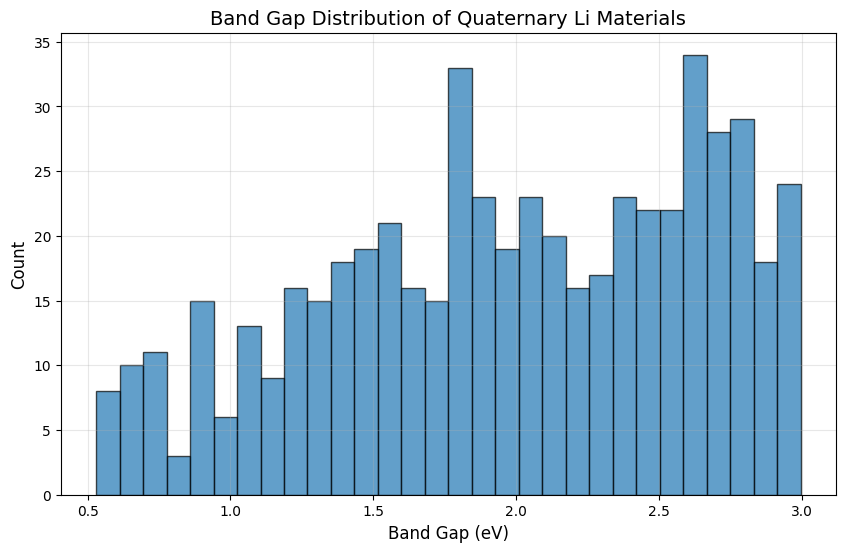

In [10]:
# Plot band gap distribution
plt.figure(figsize=(10, 6))
plt.hist(df['band_gap'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Band Gap (eV)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Band Gap Distribution of Quaternary Li Materials', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

## Thermodynamic Data

Get formation energy and other thermodynamic properties

In [11]:
with MPRester(api_key) as mpr:
    # Get detailed thermo data
    docs = mpr.materials.thermo.search(
        formula="LiFePO4",
        fields=["material_id", "formation_energy_per_atom", "energy_above_hull", "decomposes_to"]
    )
    
    for doc in docs:
        print(f"Material ID: {doc.material_id}")
        print(f"Formation energy: {doc.formation_energy_per_atom} eV/atom")
        print(f"Energy above hull: {doc.energy_above_hull} eV/atom")
        if doc.decomposes_to:
            print(f"Decomposes to: {doc.decomposes_to}")
        print("-" * 50)

Retrieving ThermoDoc documents:   0%|          | 0/141 [00:00<?, ?it/s]

Material ID: mp-1661648
Formation energy: -2.414454104166665 eV/atom
Energy above hull: 0.065752056071428 eV/atom
Decomposes to: [DecompositionProduct(material_id=MPID(mp-19017), formula='Li4 Fe4 P4 O16', amount=1.0)]
--------------------------------------------------
Material ID: mp-772138
Formation energy: -2.4295188830952372 eV/atom
Energy above hull: 0.05068727714285701 eV/atom
Decomposes to: [DecompositionProduct(material_id=MPID(mp-19017), formula='Li4 Fe4 P4 O16', amount=1.0)]
--------------------------------------------------
Material ID: mp-1176703
Formation energy: -2.409396871666666 eV/atom
Energy above hull: 0.070809288571427 eV/atom
Decomposes to: [DecompositionProduct(material_id=MPID(mp-19017), formula='Li4 Fe4 P4 O16', amount=1.0)]
--------------------------------------------------
Material ID: mp-504184
Formation energy: -2.468476188095237 eV/atom
Energy above hull: 0.011729972142857 eV/atom
Decomposes to: [DecompositionProduct(material_id=MPID(mp-19017), formula='Li4 

## Electronic Structure: Band Structure and DOS

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

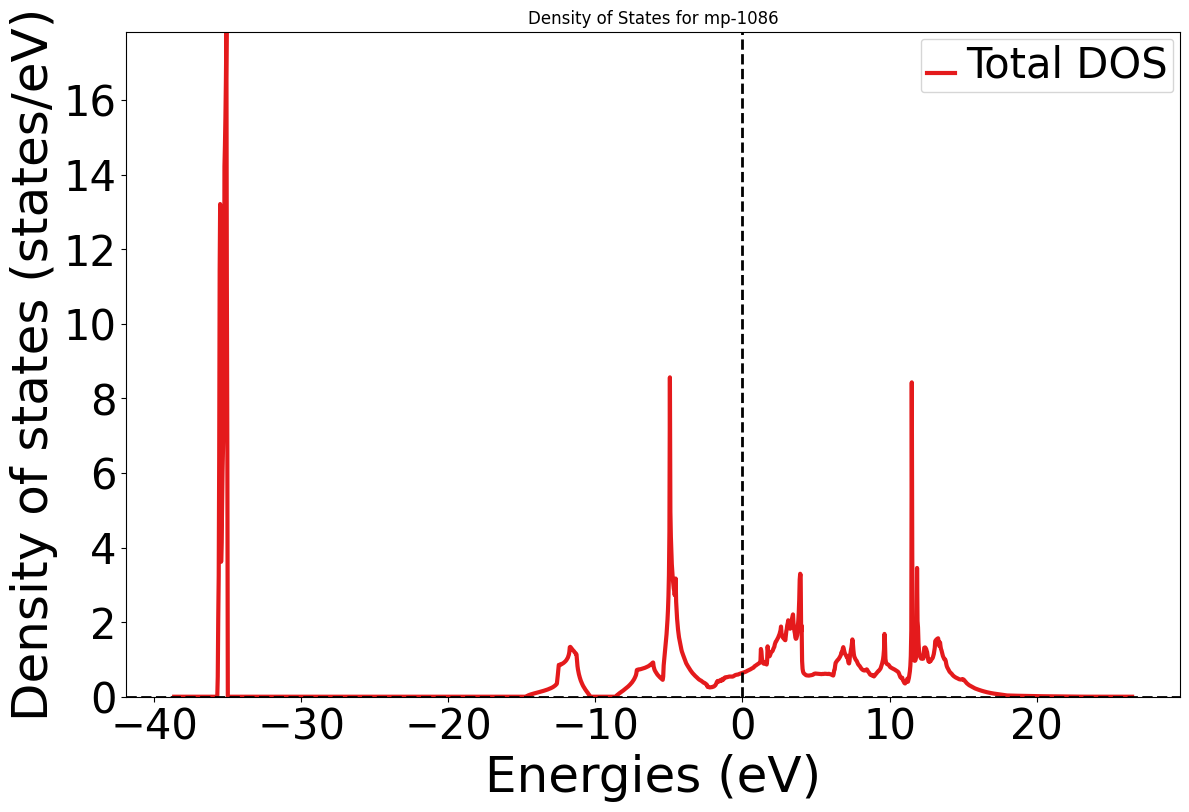

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.electronic_structure.dos import Dos
from pymatgen.electronic_structure.core import Spin

material_id = "mp-1086"

with MPRester(api_key) as mpr:
    edos = mpr.materials.electronic_structure_dos
    dos_obj = edos.get_dos_from_material_id(material_id)

# --- Convert to pymatgen object if needed ---
# Many mp-api objects are pydantic models; pymatgen plotters expect pymatgen Dos/CompleteDos objects.
if hasattr(dos_obj, "to_pymatgen"):
    dos_pm = dos_obj.to_pymatgen()
elif hasattr(dos_obj, "model_dump"):
    # Manual conversion fallback
    dd = dos_obj.model_dump()

    energies = np.array(dd.get("energies") or dd.get("energy_grid"), dtype=float)
    efermi = float(dd.get("efermi", 0.0))
    densities_raw = dd.get("densities") or dd.get("density")

    if energies is None or densities_raw is None:
        raise ValueError(f"Unexpected DOS schema keys: {list(dd.keys())}")

    if isinstance(densities_raw, dict):
        dens_keys = {str(k).lower(): k for k in densities_raw.keys()}
        densities = {}

        if "up" in dens_keys:
            densities[Spin.up] = np.array(densities_raw[dens_keys["up"]], dtype=float)
        elif "1" in dens_keys:
            densities[Spin.up] = np.array(densities_raw[dens_keys["1"]], dtype=float)

        if "down" in dens_keys:
            densities[Spin.down] = np.array(densities_raw[dens_keys["down"]], dtype=float)
        elif "-1" in dens_keys:
            densities[Spin.down] = np.array(densities_raw[dens_keys["-1"]], dtype=float)

        if not densities:
            first_key = next(iter(densities_raw))
            densities[Spin.up] = np.array(densities_raw[first_key], dtype=float)
    else:
        densities = {Spin.up: np.array(densities_raw, dtype=float)}

    dos_pm = Dos(efermi=efermi, energies=energies, densities=densities)
else:
    # Already a pymatgen Dos/CompleteDos
    dos_pm = dos_obj

# --- Plot ---
plotter = DosPlotter()
plotter.add_dos("Total DOS", dos_pm)

plt.figure(figsize=(10, 6))
plotter.get_plot()
plt.title(f"Density of States for {material_id}")
plt.show()


## Find Materials from CIF Files

You can search for materials matching a structure from a CIF file

In [13]:
# Load structure from CIF
cif_file = "lab6.cif"  # One of the CIF files in this folder
structure = Structure.from_file(cif_file)

print(f"Loaded structure: {structure.composition.reduced_formula}")
print(f"Space group: {structure.get_space_group_info()}")

# Search for similar structures
with MPRester(api_key) as mpr:
    docs = mpr.materials.summary.search(
        formula=structure.composition.reduced_formula,
        fields=["material_id", "formula_pretty", "symmetry"]
    )
    
    print(f"\nFound {len(docs)} materials with formula {structure.composition.reduced_formula}")
    for doc in docs:
        print(f"  {doc.material_id}: {doc.symmetry.symbol}")

Loaded structure: LaB6
Space group: ('Pm-3m', 221)


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]


Found 1 materials with formula LaB6
  mp-2680: Pm-3m


## Exercise: Explore Your Own Materials

Try these tasks:

1. Search for materials in a chemical system of your choice
2. Filter by properties (band gap, density, formation energy)
3. Create visualizations of property distributions
4. Compare structures with different space groups
5. Download and analyze DOS or band structure data

**Hint**: Use the `fields` parameter to specify exactly what data you need!

In [ ]:
# Your code here
# Example: Search for your favorite material system

with MPRester(api_key) as mpr:
    # Try your own search!
    pass

## Additional Resources

- **API Documentation**: https://api.materialsproject.org/docs
- **Python Client**: https://docs.materialsproject.org/
- **Pymatgen**: https://pymatgen.org/
- **MP Website**: https://materialsproject.org/
- **Migration Guide (Legacy to New)**: https://docs.materialsproject.org/downloading-data/differences-between-new-and-legacy-api